give similar figures, but for namespace 0 only (chart of top reverts, self and non-self in dif colors, use dif colors, doesn’t like blue / red.)
3 histograms
* top reverters revs (count)
* top reverted revs (count)
* top pairs (count) -- same as what we have but in namespace 0


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime

In [4]:
df = pd.read_csv('revs_scored_jan.tsv', sep='\t', header=0)

In [5]:
days = df.rev_timestamp.map(lambda ts: datetime.utcfromtimestamp(ts).day)
df['day'] = days

In [6]:
# isolate data to only data from Jan1-Jan21, reverted w/in 24 hours, revisions by a bot

sdf = df[df.day<22]
sdf_reverted = sdf[sdf.is_reverted] # w/o, still include 'none'
sdf_reverted_in_day = sdf_reverted[sdf_reverted.seconds_to_revert.astype('str').astype('int')<86400]
sdf_bots = sdf_reverted_in_day[sdf_reverted_in_day.user_is_bot]

In [7]:
# isolate namespace 0

namespace0 = sdf_bots[sdf_bots.page_namespace == 0]

In [8]:
# to do next: find matching rev_id to revert_ids of where user_is_bot is true?
sdf_another = df[df.user_is_bot]
sdf_another = sdf_another[sdf_another.is_revert]

sdf1 = namespace0.loc[namespace0.is_reverted, ["rev_id", "user_text", "revert_id"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = sdf_another[["rev_id", 'user_text', "is_self_revert"]]

In [9]:
# subset bot-bot reverts using merge

bot_bot_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [10]:
bot_pairs = bot_bot_reverts.groupby(["user_text","user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [11]:
bot_pairs

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert
0,3,EmausBot,EmausBot,294,294,294,294
1,6,RMCD bot,RMCD bot,47,47,47,47
2,2,DPL bot,DPL bot,17,17,17,17
3,4,Filedelinkerbot,Filedelinkerbot,8,8,8,8
4,1,Cyberbot II,Cyberbot II,6,6,6,6
5,7,RonBot,RonBot,2,2,2,2
6,0,ClueBot NG,EmausBot,1,1,1,1
7,5,JCW-CleanerBot,JCW-CleanerBot,1,1,1,1


In [12]:
bot_bot_reverts.groupby(["user_text","user_text_reverter"], as_index = False).sum().sort_values("rev_id", ascending=False).reset_index()

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert
0,3,EmausBot,EmausBot,258015404640,258024564260,258024564260,290
1,6,RMCD bot,RMCD bot,41272626516,41273464584,41273464584,44
2,2,DPL bot,DPL bot,14922002776,14924556522,14924556522,17
3,4,Filedelinkerbot,Filedelinkerbot,7027773933,7027774401,7027774401,0
4,1,Cyberbot II,Cyberbot II,5271125803,5271668151,5271668151,6
5,7,RonBot,RonBot,1752468744,1752586514,1752586514,2
6,0,ClueBot NG,EmausBot,878888255,878888657,878888657,0
7,5,JCW-CleanerBot,JCW-CleanerBot,878794664,878794769,878794769,1


note: why does is_self_revert column not match up with totals in above chart? shouldn't all counted things be self-reverts if user_text and user_text_reverter match up?

In [13]:
bot_bot_reverts[(bot_bot_reverts.user_text == "EmausBot") & (bot_bot_reverts.user_text_reverter == "EmausBot") & (bot_bot_reverts.is_self_revert == False)]

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
98,877003459,EmausBot,877006852,877006852,EmausBot,False
299,878468083,EmausBot,878538474,878538474,EmausBot,False
324,878842220,EmausBot,878983569,878983569,EmausBot,False
325,878842233,EmausBot,878983590,878983590,EmausBot,False


depends on how is_self_revert is computed

if there is an intervening edit by another user, doesn't count as a self revert (in our current data)

In [14]:
bot_pairs

bot_pairs["category_is_self_revert"] = False

for row in bot_pairs.itertuples():
    if row.user_text_reverter == row.user_text:
        bot_pairs.loc[row.Index, "category_is_self_revert"] = True

In [15]:
bot_pairs

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert,category_is_self_revert
0,3,EmausBot,EmausBot,294,294,294,294,True
1,6,RMCD bot,RMCD bot,47,47,47,47,True
2,2,DPL bot,DPL bot,17,17,17,17,True
3,4,Filedelinkerbot,Filedelinkerbot,8,8,8,8,True
4,1,Cyberbot II,Cyberbot II,6,6,6,6,True
5,7,RonBot,RonBot,2,2,2,2,True
6,0,ClueBot NG,EmausBot,1,1,1,1,False
7,5,JCW-CleanerBot,JCW-CleanerBot,1,1,1,1,True


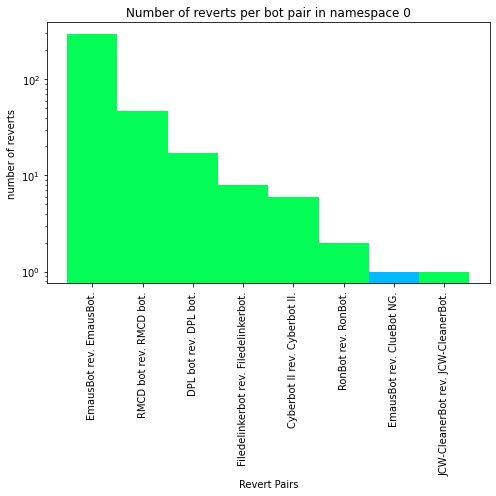

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(bot_pairs))

map = bot_pairs.category_is_self_revert.map(lambda is_self: '#03fc56' if is_self else '#03bafc')

axes.bar(y, bot_pairs.rev_id, width=1, color = map)

axes.set_title("Number of reverts per bot pair in namespace 0")
axes.set_xlabel("Revert Pairs")
axes.set_ylabel("number of reverts")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter} rev. {row.user_text}." for row in bot_pairs.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

In [17]:
top_reverted_bots = bot_bot_reverts.groupby(["user_text"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [18]:
top_reverted_bots

,index,user_text,rev_id,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,3,EmausBot,294,294,294,294,294
1,6,RMCD bot,47,47,47,47,47
2,2,DPL bot,17,17,17,17,17
3,4,Filedelinkerbot,8,8,8,8,8
4,1,Cyberbot II,6,6,6,6,6
5,7,RonBot,2,2,2,2,2
6,0,ClueBot NG,1,1,1,1,1
7,5,JCW-CleanerBot,1,1,1,1,1


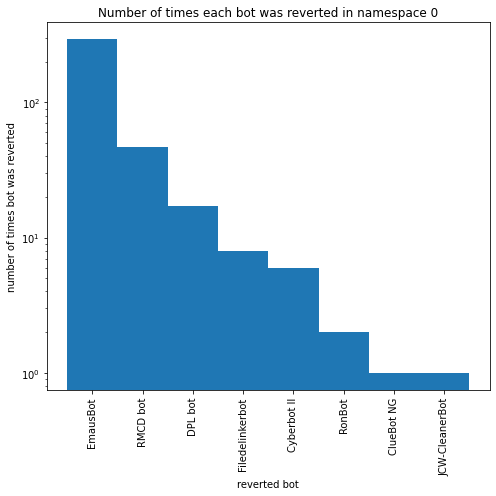

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(top_reverted_bots))

axes.bar(y, top_reverted_bots.rev_id, width=1)

axes.set_title("Number of times each bot was reverted in namespace 0")
axes.set_xlabel("reverted bot")
axes.set_ylabel("number of times bot was reverted")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text}" for row in top_reverted_bots.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

In [20]:
top_reverter_bots = bot_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [21]:
top_reverter_bots

,index,user_text_reverter,rev_id,user_text,revert_id,rev_id_reverter,is_self_revert
0,2,EmausBot,295,295,295,295,295
1,5,RMCD bot,47,47,47,47,47
2,1,DPL bot,17,17,17,17,17
3,3,Filedelinkerbot,8,8,8,8,8
4,0,Cyberbot II,6,6,6,6,6
5,6,RonBot,2,2,2,2,2
6,4,JCW-CleanerBot,1,1,1,1,1


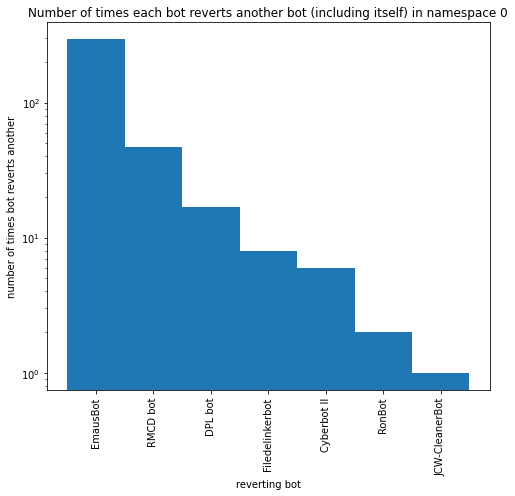

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(top_reverter_bots))

axes.bar(y, top_reverter_bots.rev_id, width=1)

axes.set_title("Number of times each bot reverts another bot (including itself) in namespace 0")
axes.set_xlabel("reverting bot")
axes.set_ylabel("number of times bot reverts another")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter}" for row in top_reverter_bots.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

In [23]:
sdf_anotherh = df[df.user_is_bot != True]
sdf_anotherh = sdf_anotherh[sdf_anotherh.is_revert]

sdf1 = namespace0.loc[namespace0.is_reverted, ["rev_id", "user_text", "revert_id"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = sdf_anotherh[["rev_id", 'user_text', "is_self_revert"]]

In [24]:
# subset human-bot reverts using merge

human_bot_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [25]:
human_bot_reverts

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,876228043,ClueBot NG,876289025,876289025,TheDeviantPro,False
1,876234293,RonBot,876263657,876263657,180.150.79.160,False
2,876234459,RonBot,876316868,876316868,Mrceleb2007,False
3,876234505,RonBot,876317975,876317975,CiaPan,False
4,876234555,RonBot,876235497,876235497,PhilKnight,False
...,...,...,...,...,...,...
1477,879531323,ClueBot NG,879556942,879556942,2A02:C7F:8E7E:4D00:10E7:FD9F:1401:A1C1,False
1478,879542039,ClueBot NG,879542102,879542102,125M L0CK,False
1479,879542895,ClueBot NG,879544292,879544292,MRD2014,False
1480,879543329,MusikBot,879543983,879543983,FlightTime,False


In [26]:
human_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

,index,user_text_reverter,rev_id,user_text,revert_id,rev_id_reverter,is_self_revert
0,416,Inter&anthro,171,171,171,171,171
1,509,Mattythewhite,96,96,96,96,96
2,372,Ganeshk,57,57,57,57,57
3,380,GiantSnowman,45,45,45,45,45
4,653,The Anome,39,39,39,39,39
...,...,...,...,...,...,...,...
714,233,Alexanderlee,1,1,1,1,1
715,234,Alexnd,1,1,1,1,1
716,235,AmericanAir88,1,1,1,1,1
717,236,Amorymeltzer,1,1,1,1,1


In [27]:
top_human_reverters = human_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index().head(10)
top_human_reverters

,index,user_text_reverter,rev_id,user_text,revert_id,rev_id_reverter,is_self_revert
0,416,Inter&anthro,171,171,171,171,171
1,509,Mattythewhite,96,96,96,96,96
2,372,Ganeshk,57,57,57,57,57
3,380,GiantSnowman,45,45,45,45,45
4,653,The Anome,39,39,39,39,39
5,487,Lugnuts,35,35,35,35,35
6,116,2605:E000:2407:4F00:C49:D6F3:A5CF:CEFE,20,20,20,20,20
7,266,BlameRuiner,14,14,14,14,14
8,357,Fbergo,12,12,12,12,12
9,544,Onel5969,10,10,10,10,10


In [28]:
top_bots_reverted_byh = human_bot_reverts.groupby(["user_text"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index().head(10)
top_bots_reverted_byh

,index,user_text,rev_id,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,6,ClueBot NG,466,466,466,466,466
1,27,RonBot,429,429,429,429,429
2,0,AnomieBOT,214,214,214,214,214
3,15,Ganeshbot,58,58,58,58,58
4,7,CommonsDelinker,46,46,46,46,46
5,30,The Anomebot2,39,39,39,39,39
6,24,MusikBot,35,35,35,35,35
7,20,JJMC89 bot,34,34,34,34,34
8,13,EmausBot,29,29,29,29,29
9,14,Filedelinkerbot,24,24,24,24,24


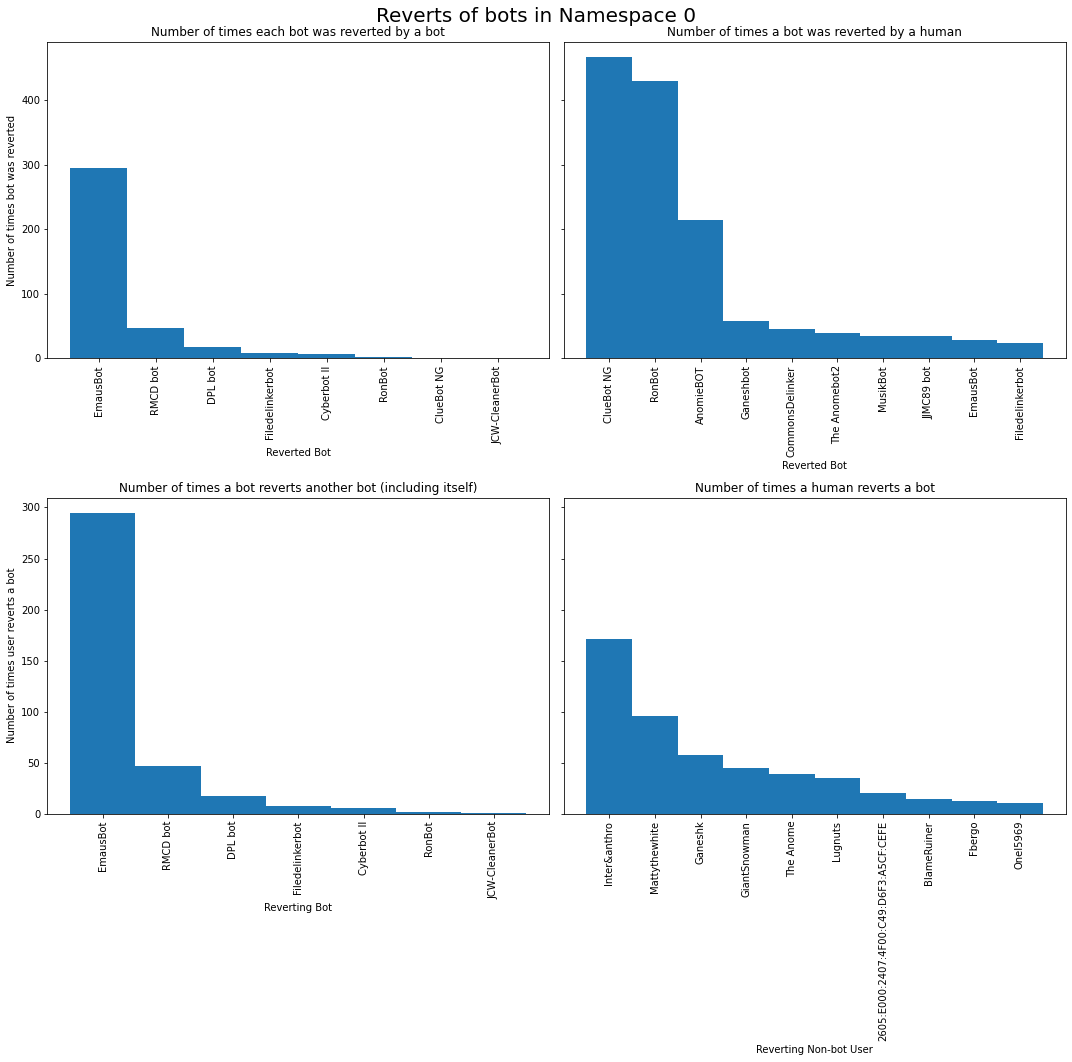

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey = 'row')
fig.suptitle("Reverts of bots in Namespace 0", fontsize = 20)

ax = axes[0,0]
#reverted bots (by other bots)
y = range(len(top_reverted_bots))
ax.bar(y, top_reverted_bots.rev_id, width=1)
ax.set_title("Number of times each bot was reverted by a bot")
ax.set_xlabel("Reverted Bot")
ax.set_ylabel("Number of times bot was reverted")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text}" for row in top_reverted_bots.itertuples()], rotation='vertical')


ax = axes[1,0]
#bots that revert other bots
y = range(len(top_reverter_bots))
ax.bar(y, top_reverter_bots.rev_id, width=1)
ax.set_title("Number of times a bot reverts another bot (including itself)")
ax.set_xlabel("Reverting Bot")
ax.set_ylabel("Number of times user reverts a bot")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text_reverter}" for row in top_reverter_bots.itertuples()], rotation='vertical')


ax = axes[1,1]
y = range(len(top_human_reverters))
ax.bar(y, top_human_reverters.rev_id, width=1)
ax.set_title("Number of times a human reverts a bot")
ax.set_xlabel("Reverting Non-bot User")
#ax.set_ylabel("Number of times bot was reverted")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text_reverter}" for row in top_human_reverters.itertuples()], rotation='vertical')

ax = axes[0,1]
y = range(len(top_bots_reverted_byh))
ax.bar(y, top_bots_reverted_byh.rev_id, width=1)
ax.set_title("Number of times a bot was reverted by a human")
ax.set_xlabel("Reverted Bot")
#ax.set_ylabel("Number of times bot was reverted")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text}" for row in top_bots_reverted_byh.itertuples()], rotation='vertical')

fig.tight_layout()
plt.show()

In [30]:
human_bot_reverts[human_bot_reverts.user_text_reverter == "Inter&anthro"].head()

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
385,877203224,RonBot,877206452,877206452,Inter&anthro,False
415,877206467,RonBot,877206524,877206524,Inter&anthro,False
424,877207162,RonBot,877207218,877207218,Inter&anthro,False
427,877207216,RonBot,877207382,877207382,Inter&anthro,False
429,877207266,RonBot,877207413,877207413,Inter&anthro,False


# RonBot

https://en.wikipedia.org/wiki/User:RonBot

Bot is no longer active, operator has since passed away

tried to look for discussion of malfunctionmost recent talk on user's page is from 2020 and can't find anything there

discussion about brokenimage task possibly being broken in March 2019
https://en.wikipedia.org/wiki/Wikipedia:Bots/Noticeboard/Archive_13#User:RonBot_trouble_possibly_in_need_of_intervention

discussion about footballer category task in July 2018 https://en.wikipedia.org/wiki/Wikipedia:Bot_requests/Archive_76#Association_footballers_not_categorized_by_position


## Random sample of edits reverted by a human

In [36]:
len(human_bot_reverts[human_bot_reverts.user_text == "RonBot"])

429

In [38]:
human_bot_reverts[human_bot_reverts.user_text == "RonBot"].sample(n=20, random_state=1).reset_index()

,index,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,537,877208766,RonBot,877271049,877271049,Inter&anthro,False
1,518,877208664,RonBot,877276144,877276144,Inter&anthro,False
2,474,877208212,RonBot,877208417,877208417,Inter&anthro,False
3,587,877209086,RonBot,877269769,877269769,Inter&anthro,False
4,372,877202703,RonBot,877218672,877218672,GiantSnowman,False
5,482,877208346,RonBot,877277625,877277625,Inter&anthro,False
6,686,877277070,RonBot,877295106,877295106,Jmorrison230582,False
7,23,876292953,RonBot,876296168,876296168,Vsmith,False
8,552,877208884,RonBot,877270435,877270435,Inter&anthro,False
9,741,877279563,RonBot,877281409,877281409,Walter Görlitz,False


0. 877208766 on Adil Mezgour page, for task 7. ronbot adds category (footballers not categorized by position). user inter%anthro undoes it, says position category already present. indeed, article does list category "association football forwards" already
1. 877208664 on Adham El Idrissi page, for task 7. ronbot adds category. user inter&anthro deletes it, says position category already present. indeed, category "association football forwards" is already present.
2. 877208212 on Adamo Coulibaly page, for task 7. ronbot adds category (footballers not categorized by position). user Inter%anthro undoes it, says position category already present. indeed, article does list category "association football forwards" already
3. 877209086 on dif page, for task 7. ronbot adds category (footballers not categorized by position). user Inter%anthro undoes it, says position category already present. indeed, article does list category "association football midfielders" already
4. 877202703 same as above, user GiantSnowman reverts, in midfielders category
5. 877208346 same as above, user inter&anthro reverts, in defenders category, edits are 12 hours apart on Jan 7
6. 877277070 same as above, user Jmorrison230582 reverts, in category forwards, edits are 2 hours apart on Jan 7
7. 876292953 on Eastern world page, RonBot adds broken image template. another user vsmith reverts to edit before alleged vandalism that broke the image ***not a malfunction***. edits about 30 mins apart, on Jan 1.
8. 877208884 same footballer edits, reverting user is Inter&anthro, forwards category already present, edits about 12 hours apart on Jan 7
9. 877279563 same footballer edits, reverting user is walter gorlitz, in category defenders, about 10 mins apart 7 Jan
10. 877208746 same footballer edits, reverting user is Inter&anthro, in category defenders, edits about 11 hours apart on Jan 7
11. 877277582 same footballer edits, reverting user Mattythewhite, in category midfielders,  edits about 7 hours apart on Jan 7
12. 876293084 on Johnny Sins page, RonBot adds a BrokenImage template. user Gotitbro reverts, says no broken image. indeed the image seems to be correct.
13. 879469682 on Daksha page, RonBot adds BrokenImage template (task 12). user KylieTastic reverts to a different edit to fix the name of the image. ***not a malfunction***
14. 877208422 same football edits, reverting user is GiantSnowman, in category midfielders, edits are about 3 hours apart Jan 7
15. 877208840 same football edits, reverting user is inter&anthro, in category defenders, 12 hours apart on Jan 7
16. 877209113 same football edits, reverting user is Inter&anthro, in category defenders, edits about 1 hour apart on Jan 7
17. 877208707 same football edits, reverting user Inter&anthro, in category forwards, edits about 11 hours apart on Jan 7
18. 877201219 same football edits, reverting user Mattythewhite, in category forwards, edits about 20 hours apart. first edit is 30 mins before midnight on 6 Jan, second 18:00 on Jan 7
19. 877207378 same football edits, reverting user Daemonickangaroo2018, in category midfielders,  edits about 13 hours apart on Jan 7